Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier

08-15 DATE : Date YYYYMMDD

17-21 TG   : mean temperature in 0.1 &#176;C

23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).

Blended and updated with sources: 111448 127488 128124 

See file sources.txt and stations.txt for more info.

In [49]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

In [50]:
FILE_PATH = "/Users/elizavetabugaeva/Documents/Spiced/weekly_milestones/week_07/ECA_blended_custom/TG_STAID002759.txt"

df = pd.read_csv(
FILE_PATH,
#start from row 20
skiprows=19,
skipinitialspace = True,
#column #1 is dates in our original data 
parse_dates = [1]
)

In [51]:
df

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0


In [52]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0


In [53]:
df.tail()

,SOUID,DATE,TG,Q_TG
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0
53780,111448,2023-03-31,108,0


In [54]:
df_missing = df[df['Q_TG']==9]

In [55]:
df_missing['DATE'].min()

Timestamp('1945-04-25 00:00:00')

In [56]:
df_missing['DATE'].max()

Timestamp('1945-11-05 00:00:00')

In [57]:
#number of days with missing vallues
missing_days= (df_missing['DATE'].max() - df_missing['DATE'].min()).days +1
missing_days

195

In [58]:
#check is all missing days actually miss values
missing_days == df_missing.shape[0]

True

## Data Preprocessing

Missing days need to be inputed for the model to work

In [59]:
from dateutil.relativedelta import relativedelta

In [60]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10

In [61]:
# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: clean_temp(df,x),
    axis=1
)

In [62]:
#check that values are filled out
df[df['DATE']=='1945-07-25']

,SOUID,DATE,TG,Q_TG,TEMP
25407,127488,1945-07-25,-9999,9,20.6


In [63]:
df

,SOUID,DATE,TG,Q_TG,TEMP
0,127488,1876-01-01,22,0,2.2
1,127488,1876-01-02,25,0,2.5
2,127488,1876-01-03,3,0,0.3
3,127488,1876-01-04,-58,0,-5.8
4,127488,1876-01-05,-98,0,-9.8
...,...,...,...,...,...
53776,111448,2023-03-27,34,0,3.4
53777,111448,2023-03-28,35,0,3.5
53778,111448,2023-03-29,66,0,6.6
53779,111448,2023-03-30,117,0,11.7


### Train-test split

In [64]:
df.columns = df.columns.str.lower()
clean_df = df.set_index('date')[['temp']]

In [65]:
clean_df.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [66]:
df.shape

(53781, 5)

In [67]:
train = clean_df[:'2022-12-31']
train.shape

(53691, 1)

In [68]:
test = clean_df['2023-01-01':]

In [69]:
test.shape

(90, 1)

In [70]:
train.to_csv('temp_train.csv')
test.to_csv('temp_test.csv')

### Split data to noise and denoised

In [71]:
#import savitzky-golay filter
from scipy.signal import savgol_filter

In [72]:
train['denoised']=savgol_filter(np.array(train['temp']),99,3, mode='nearest')

In [73]:
train['denoised']

date
1876-01-01   -0.659391
1876-01-02   -0.772946
1876-01-03   -0.858296
1876-01-04   -1.025494
1876-01-05   -1.151521
                ...   
2022-12-27    6.827954
2022-12-28    7.212065
2022-12-29    7.611574
2022-12-30    8.021626
2022-12-31    8.411407
Name: denoised, Length: 53691, dtype: float64

<AxesSubplot:xlabel='date'>

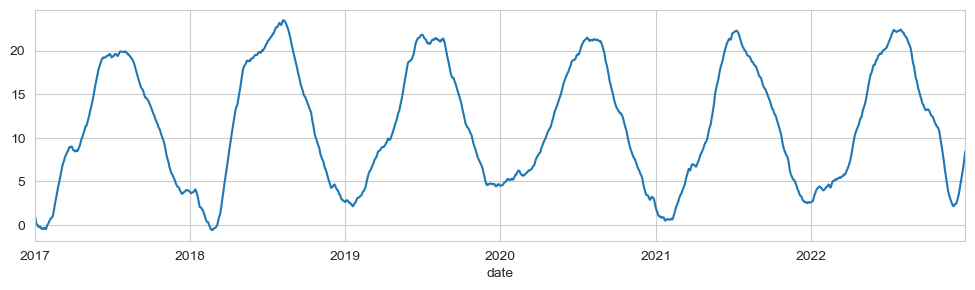

In [74]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train['denoised']['2017-01-01':'2022-12-31'].plot()

In [75]:
test['denoised']=savgol_filter(np.array(test['temp']),99,3, mode='nearest')

### Noise

In [76]:
train['noise'] = train['temp'] - train['denoised']

In [77]:
test['noise'] = test['temp'] - test['temp']

<AxesSubplot:xlabel='date'>

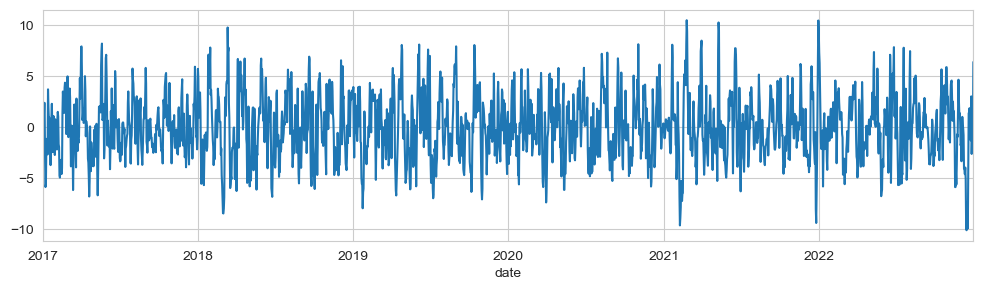

In [78]:
train['noise']['2017-01-01':'2022-12-31'].plot()

## Working with denoised data only

In [79]:
#calculate qcd
def qcd_variance(series,window=12): #12 because we work with months
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")
    
    #this function tells you if the series varies a lot or not

In [80]:
qcd_variance(train['denoised'])

quartile coefficient of dispersion: 0.777515


In [91]:
from sklearn.preprocessing import PowerTransformer


In [92]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)

In [95]:
train['denoised_1'] = pt.fit_transform(train[['denoised']])

In [96]:
qcd_variance(train['denoised_1'])

quartile coefficient of dispersion: 0.77355


In [99]:
train['denoised_log']=np.log1p(train['denoised'])

In [100]:
qcd_variance(train['denoised_log'])

quartile coefficient of dispersion: 0.887667


quartile coefficient of dispersion is close to 1 and tranformationd do not help -> will be using multiplicative model in the end 

## Baseline Model

### Trend

In [98]:
train['timestep']= list(range(0,train.shape[0]))

In [103]:
X_trend = train[['timestep']]
y_trend = train['denoised']

In [104]:
trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [105]:
trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [106]:
train['trend_denoised'] = trend_model.predict(X_trend)

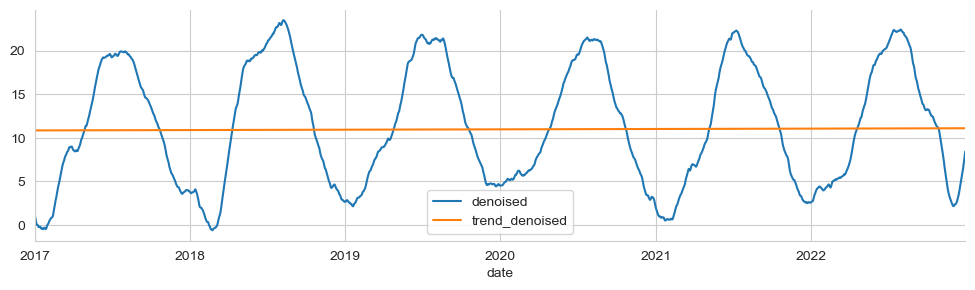

In [108]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['denoised','trend_denoised']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

### Seasonality

In [110]:
train['detrended_den'] = train['denoised'] - train['trend_denoised']

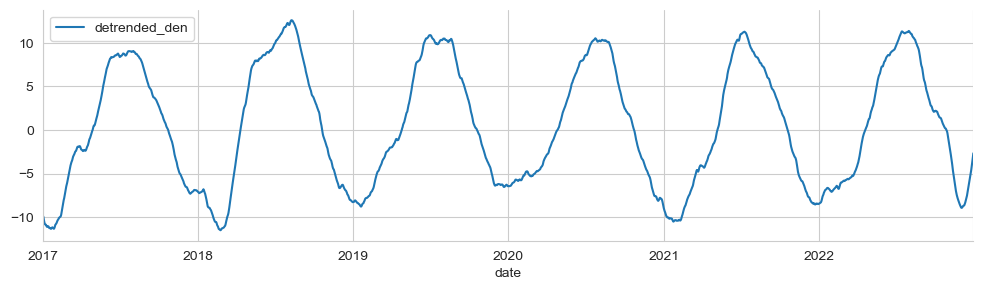

In [112]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended_den']['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

In [113]:
train.head()

,temp,denoised,noise,denoised_1,timestep,denoised_log,trend_denoised,detrended_den
date,,,,,,,,
1876-01-01,2.2,-0.659391,2.859391,-0.680260,0,-1.077019,9.234793,-9.894184
1876-01-02,2.5,-0.772946,3.272946,-0.800961,1,-1.482567,9.234747,-10.007693
1876-01-03,0.3,-0.858296,1.158296,-0.892261,2,-1.954014,9.234700,-10.092996
1876-01-04,-5.8,-1.025494,-4.774506,-1.072477,3,NaN,9.234653,-10.260147
1876-01-05,-9.8,-1.151521,-8.648479,-1.209440,4,NaN,9.234606,-10.386128


In [133]:
# Convert the index to a pandas DatetimeIndex
train.index = pd.to_datetime(train.index)

# Extract day of the year from the index and normalize it to range from 0 to 1
day_of_year = train.index.dayofyear
day_of_year_normalized = (day_of_year - 1) / 365.24

# Create a seasonality column with values ranging from 0 to 1
train['seasonality'] = day_of_year_normalized

In [134]:
X_season = train[['seasonality']]
y_season = train['detrended_den']

In [135]:
seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [136]:
seasonality_model.fit(X_season, y_season)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [137]:
train['seasonality'] = seasonality_model.predict(X_season)

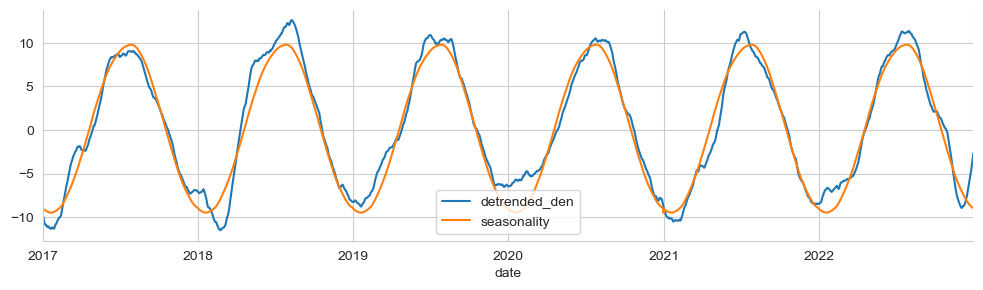

In [138]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended_den','seasonality']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

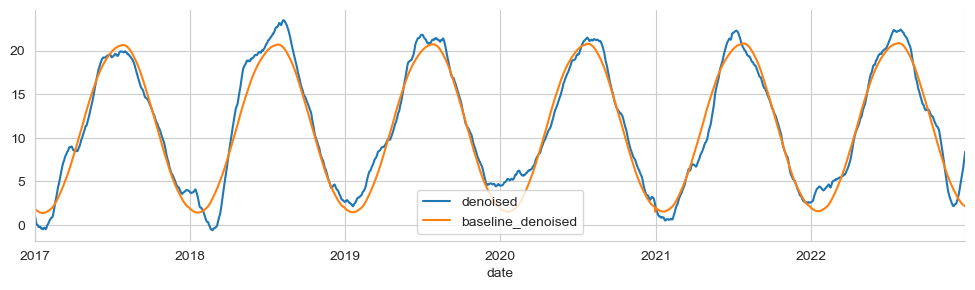

In [142]:
#Plot Baseline Model
# combine trend and seasonality

train['baseline_denoised'] = train['trend_denoised'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['denoised','baseline_denoised']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

## Model Remainder

In [149]:
train['remainder_denoised'] = train['denoised'] - train['baseline_denoised']

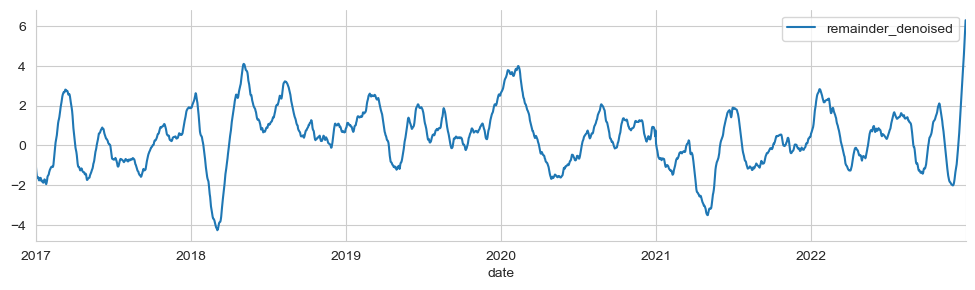

In [150]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder_denoised']['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

In [151]:
qcd_variance(train['remainder_denoised'])

quartile coefficient of dispersion: 0.756349
